# Approach 2: Hybrid Genre Grouping

## Spotify Song Popularity Prediction

**Improvement Strategy:** Group similar genres into broader categories while keeping distinct major genres separate.

**Hypothesis:** Grouping similar genres (e.g., all rock variants together) reduces feature sparsity while retaining meaningful genre information.

---

### Previous Results:
- **Baseline (no genre):** CV RMSE ~11.27, Val R² ~0.39
- **Approach 1 (top 15 separate):** CV RMSE ~10.93, Val R² ~0.41

**Goal:** See if hybrid grouping can improve further.

---
## 1. Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


---
## 2. Load Data

In [2]:
# Load training and test data
train_df = pd.read_csv('./data/CS98XRegressionTrain.csv')
test_df = pd.read_csv('./data/CS98XRegressionTest.csv')

print("="*60)
print("DATA LOADED")
print("="*60)
print(f"Training set: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
print(f"Test set:     {test_df.shape[0]} rows, {test_df.shape[1]} columns")

DATA LOADED
Training set: 453 rows, 15 columns
Test set:     114 rows, 14 columns


---
## 3. Analyze All Genres

Let's examine all unique genres to identify grouping opportunities.

In [3]:
# Handle empty genres and NaN values
train_df['top genre'] = train_df['top genre'].fillna('Unknown').replace('', 'Unknown')
test_df['top genre'] = test_df['top genre'].fillna('Unknown').replace('', 'Unknown')

# Get all unique genres
all_genres = train_df['top genre'].value_counts()
print("="*60)
print(f"ALL UNIQUE GENRES ({len(all_genres)} total)")
print("="*60)
print(all_genres.to_string())

ALL UNIQUE GENRES (87 total)
top genre
adult standards            68
album rock                 66
dance pop                  61
brill building pop         16
glam rock                  16
Unknown                    15
europop                    14
dance rock                 13
boy band                   10
british invasion            8
art rock                    7
disco                       7
bubblegum dance             7
atl hip hop                 6
eurodance                   6
barbadian pop               6
deep adult standards        6
classic soul                5
british soul                5
soft rock                   5
pop                         5
east coast hip hop          4
classic uk pop              4
doo-wop                     4
disco house                 3
g funk                      3
new wave pop                3
bronx hip hop               2
glam metal                  2
merseybeat                  2
chicago soul                2
permanent wave              2
c

In [4]:
# Identify genres containing common keywords
keywords = ['rock', 'pop', 'dance', 'soul', 'disco', 'r&b', 'hip hop', 'rap', 'electronic', 'metal']

print("="*60)
print("GENRES BY KEYWORD")
print("="*60)

for keyword in keywords:
    matching = [g for g in all_genres.index if keyword.lower() in g.lower()]
    if matching:
        total_count = sum(all_genres[g] for g in matching)
        print(f"\n'{keyword.upper()}' genres ({len(matching)} genres, {total_count} songs):")
        for g in matching:
            print(f"  - {g}: {all_genres[g]}")

GENRES BY KEYWORD

'ROCK' genres (13 genres, 119 songs):
  - album rock: 66
  - glam rock: 16
  - dance rock: 13
  - art rock: 7
  - soft rock: 5
  - blues rock: 2
  - classic rock: 2
  - celtic rock: 2
  - country rock: 2
  - german alternative rock: 1
  - rock-and-roll: 1
  - australian rock: 1
  - alternative rock: 1

'POP' genres (18 genres, 123 songs):
  - dance pop: 61
  - brill building pop: 16
  - europop: 14
  - barbadian pop: 6
  - pop: 5
  - classic uk pop: 4
  - new wave pop: 3
  - art pop: 2
  - belgian pop: 2
  - canadian pop: 2
  - baroque pop: 1
  - bubblegum pop: 1
  - afropop: 1
  - hip pop: 1
  - italian pop: 1
  - classic danish pop: 1
  - britpop: 1
  - bow pop: 1

'DANCE' genres (7 genres, 90 songs):
  - dance pop: 61
  - dance rock: 13
  - bubblegum dance: 7
  - eurodance: 6
  - belgian dance: 1
  - german dance: 1
  - british dance band: 1

'SOUL' genres (3 genres, 12 songs):
  - classic soul: 5
  - british soul: 5
  - chicago soul: 2

'DISCO' genres (2 genres, 

---
## 4. Define Hybrid Genre Groups

**Strategy:**
- Group related genres (rock variants, pop variants, etc.)
- Keep high-frequency genres that are distinct
- Create an 'other' category for rare genres

In [5]:
# Define genre groupings based on the data analysis
def get_genre_group(genre):
    """
    Map individual genres to broader groups.
    """
    genre_lower = genre.lower()
    
    # Rock variants
    if any(word in genre_lower for word in ['rock', 'metal', 'punk', 'grunge']):
        return 'rock'
    
    # Pop variants
    if any(word in genre_lower for word in ['pop']) and 'hip hop' not in genre_lower:
        return 'pop'
    
    # Dance/Electronic variants
    if any(word in genre_lower for word in ['dance', 'disco', 'house', 'techno', 'edm', 'electronic', 'trance']):
        return 'dance_electronic'
    
    # Soul/R&B variants
    if any(word in genre_lower for word in ['soul', 'r&b', 'motown', 'funk']):
        return 'soul_rnb'
    
    # Hip Hop/Rap variants
    if any(word in genre_lower for word in ['hip hop', 'rap', 'trap']):
        return 'hiphop_rap'
    
    # Standards/Classic
    if any(word in genre_lower for word in ['standards', 'classic', 'traditional']):
        return 'standards'
    
    # Euro variants
    if any(word in genre_lower for word in ['euro', 'british', 'italian', 'french', 'german', 'swedish']):
        return 'european'
    
    # Latin variants
    if any(word in genre_lower for word in ['latin', 'reggaeton', 'salsa', 'bachata', 'spanish']):
        return 'latin'
    
    # Country
    if 'country' in genre_lower:
        return 'country'
    
    # Everything else
    return 'other'

# Apply grouping to training and test data
train_df['genre_group'] = train_df['top genre'].apply(get_genre_group)
test_df['genre_group'] = test_df['top genre'].apply(get_genre_group)

# Show the mapping
print("="*60)
print("GENRE GROUPING RESULTS")
print("="*60)
group_counts = train_df['genre_group'].value_counts()
print(f"\nNumber of genre groups: {len(group_counts)}")
print(f"\nGroup distribution:")
print(group_counts)

GENRE GROUPING RESULTS

Number of genre groups: 10

Group distribution:
genre_group
rock                124
pop                 123
standards            75
other                54
dance_electronic     28
hiphop_rap           18
soul_rnb             17
european             12
latin                 1
country               1
Name: count, dtype: int64


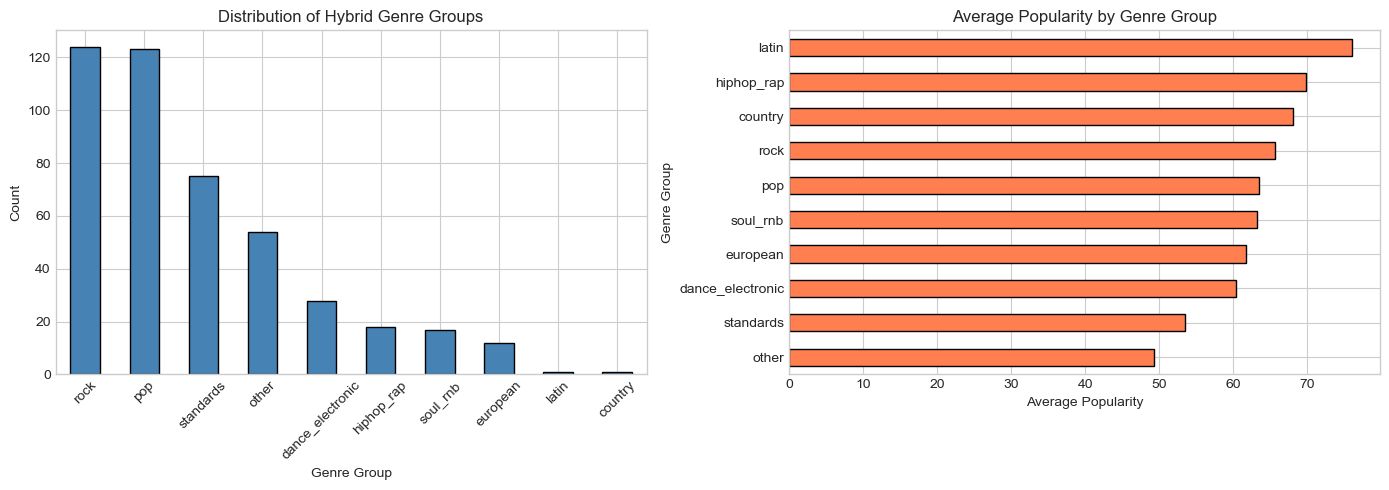


Popularity by Genre Group:
                   mean    std  count
genre_group                          
latin             76.00    NaN      1
hiphop_rap        69.83  10.12     18
country           68.00    NaN      1
rock              65.58   9.92    124
pop               63.47  12.35    123
soul_rnb          63.24   9.65     17
european          61.75  18.23     12
dance_electronic  60.36   8.22     28
standards         53.45  12.62     75
other             49.30  16.27     54


In [6]:
# Visualize genre groups
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of genre groups
group_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Genre Group')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Hybrid Genre Groups')
axes[0].tick_params(axis='x', rotation=45)

# Average popularity by genre group
group_pop = train_df.groupby('genre_group')['pop'].mean().sort_values()
group_pop.plot(kind='barh', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_xlabel('Average Popularity')
axes[1].set_ylabel('Genre Group')
axes[1].set_title('Average Popularity by Genre Group')

plt.tight_layout()
plt.show()

print("\nPopularity by Genre Group:")
group_stats = train_df.groupby('genre_group')['pop'].agg(['mean', 'std', 'count']).round(2)
print(group_stats.sort_values('mean', ascending=False))

In [7]:
# Show which original genres mapped to each group
print("="*60)
print("GENRE MAPPING DETAILS")
print("="*60)

for group in sorted(train_df['genre_group'].unique()):
    original_genres = train_df[train_df['genre_group'] == group]['top genre'].value_counts()
    print(f"\n{group.upper()} ({len(original_genres)} genres, {original_genres.sum()} songs):")
    for genre, count in original_genres.items():
        print(f"  - {genre}: {count}")

GENRE MAPPING DETAILS

COUNTRY (1 genres, 1 songs):
  - country: 1

DANCE_ELECTRONIC (9 genres, 28 songs):
  - disco: 7
  - bubblegum dance: 7
  - eurodance: 6
  - disco house: 3
  - deep house: 1
  - german dance: 1
  - british dance band: 1
  - belgian dance: 1
  - bubble trance: 1

EUROPEAN (4 genres, 12 songs):
  - british invasion: 8
  - british folk: 2
  - british blues: 1
  - british comedy: 1

HIPHOP_RAP (6 genres, 18 songs):
  - atl hip hop: 6
  - east coast hip hop: 4
  - hip hop: 2
  - detroit hip hop: 2
  - chicago rap: 2
  - bronx hip hop: 2

LATIN (1 genres, 1 songs):
  - latin: 1

OTHER (23 genres, 54 songs):
  - Unknown: 15
  - boy band: 10
  - doo-wop: 4
  - big room: 2
  - chanson: 2
  - merseybeat: 2
  - permanent wave: 2
  - bebop: 2
  - neo mellow: 1
  - uk garage: 1
  - afrobeat: 1
  - drone folk: 1
  - australian talent show: 1
  - blues: 1
  - boogaloo: 1
  - canadian folk: 1
  - american folk revival: 1
  - yodeling: 1
  - hi-nrg: 1
  - louisiana blues: 1
  - m

---
## 5. Feature Engineering: One-Hot Encode Genre Groups

In [8]:
# One-hot encode genre groups
train_encoded = train_df.copy()
test_encoded = test_df.copy()

# Create dummy variables
train_dummies = pd.get_dummies(train_encoded['genre_group'], prefix='genre')
test_dummies = pd.get_dummies(test_encoded['genre_group'], prefix='genre')

# Ensure both have the same columns
all_genre_cols = list(set(train_dummies.columns) | set(test_dummies.columns))
for col in all_genre_cols:
    if col not in train_dummies.columns:
        train_dummies[col] = 0
    if col not in test_dummies.columns:
        test_dummies[col] = 0

# Add to dataframes
train_encoded = pd.concat([train_encoded, train_dummies], axis=1)
test_encoded = pd.concat([test_encoded, test_dummies], axis=1)

print(f"Created {len(all_genre_cols)} genre group features:")
for col in sorted(all_genre_cols):
    print(f"  - {col}")

Created 10 genre group features:
  - genre_country
  - genre_dance_electronic
  - genre_european
  - genre_hiphop_rap
  - genre_latin
  - genre_other
  - genre_pop
  - genre_rock
  - genre_soul_rnb
  - genre_standards


---
## 6. Prepare Features

In [9]:
# Define feature sets
numerical_features = ['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch']

# Get genre features (exclude string columns like 'genre_group')
genre_features = [col for col in train_encoded.columns if col.startswith('genre_') and train_encoded[col].dtype in ['int64', 'uint8', 'float64', 'bool']]

# Combine all features
all_features = numerical_features + genre_features

print("="*60)
print("FEATURE SUMMARY")
print("="*60)
print(f"Numerical features: {len(numerical_features)}")
print(f"Genre features:     {len(genre_features)}")
print(f"Total features:     {len(all_features)}")
print(f"\nCompared to Approach 1: 25 features (9 numerical + 16 genre)")
print(f"Approach 2 has:         {len(all_features)} features (fewer genre categories)")
print(f"\nGenre features: {genre_features}")

FEATURE SUMMARY
Numerical features: 9
Genre features:     10
Total features:     19

Compared to Approach 1: 25 features (9 numerical + 16 genre)
Approach 2 has:         19 features (fewer genre categories)

Genre features: ['genre_country', 'genre_dance_electronic', 'genre_european', 'genre_hiphop_rap', 'genre_latin', 'genre_other', 'genre_pop', 'genre_rock', 'genre_soul_rnb', 'genre_standards']


In [10]:
# Create feature matrices
X = train_encoded[all_features].copy()
y = train_encoded['pop'].copy()
X_test_final = test_encoded[all_features].copy()

print(f"Training X shape: {X.shape}")
print(f"Training y shape: {y.shape}")
print(f"Test X shape:     {X_test_final.shape}")

Training X shape: (453, 19)
Training y shape: (453,)
Test X shape:     (114, 19)


In [11]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples:   {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples:   362
Validation samples: 91


In [12]:
# Scale numerical features only
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test_final.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test_final[numerical_features])

# Full training set scaled
scaler_full = StandardScaler()
X_full_scaled = X.copy()
X_full_scaled[numerical_features] = scaler_full.fit_transform(X[numerical_features])
X_test_final_scaled = X_test_final.copy()
X_test_final_scaled[numerical_features] = scaler_full.transform(X_test_final[numerical_features])

print("Numerical features scaled (genre features kept as binary 0/1)")

Numerical features scaled (genre features kept as binary 0/1)


---
## 7. Model Training and Evaluation

In [13]:
# Helper function
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

results = {}

In [14]:
# Train and evaluate each model
print("="*70)
print("MODEL TRAINING WITH HYBRID GENRE GROUPS")
print("="*70)

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Use scaled data for linear models, unscaled for tree-based
    if any(keyword in name for keyword in ['Linear', 'Ridge', 'Lasso']):
        X_tr = X_train_scaled.values
        X_va = X_val_scaled.values
        X_full = X_full_scaled.values
    else:
        X_tr = X_train.values
        X_va = X_val.values
        X_full = X.values
    
    # Train
    model.fit(X_tr, y_train)
    
    # Predict
    train_pred = model.predict(X_tr)
    val_pred = model.predict(X_va)
    
    # Metrics
    train_rmse = calculate_rmse(y_train, train_pred)
    val_rmse = calculate_rmse(y_val, val_pred)
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_full, y, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores.mean()
    cv_std = cv_scores.std()
    
    results[name] = {
        'Train RMSE': train_rmse,
        'Val RMSE': val_rmse,
        'CV RMSE': cv_rmse,
        'CV Std': cv_std,
        'Train R2': train_r2,
        'Val R2': val_r2
    }
    
    print(f"  Train RMSE: {train_rmse:.4f}  |  Val RMSE: {val_rmse:.4f}")
    print(f"  CV RMSE:    {cv_rmse:.4f} (+/- {cv_std:.4f})")
    print(f"  Train R²:   {train_r2:.4f}  |  Val R²:  {val_r2:.4f}")

MODEL TRAINING WITH HYBRID GENRE GROUPS

--- Linear Regression ---
  Train RMSE: 10.1620  |  Val RMSE: 12.3488
  CV RMSE:    11.1367 (+/- 0.9295)
  Train R²:   0.3893  |  Val R²:  0.3183

--- Ridge Regression ---
  Train RMSE: 10.1699  |  Val RMSE: 12.2912
  CV RMSE:    11.1176 (+/- 0.9471)
  Train R²:   0.3883  |  Val R²:  0.3246

--- Lasso Regression ---
  Train RMSE: 10.2372  |  Val RMSE: 12.0482
  CV RMSE:    11.0477 (+/- 0.9927)
  Train R²:   0.3802  |  Val R²:  0.3510

--- Random Forest ---


  Train RMSE: 4.9747  |  Val RMSE: 11.3877
  CV RMSE:    11.1003 (+/- 0.8043)
  Train R²:   0.8536  |  Val R²:  0.4202

--- Gradient Boosting ---


  Train RMSE: 2.2818  |  Val RMSE: 12.5124
  CV RMSE:    11.8380 (+/- 0.9254)
  Train R²:   0.9692  |  Val R²:  0.3001


In [15]:
# Results summary
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('CV RMSE')

print("="*70)
print("MODEL COMPARISON - WITH HYBRID GENRE GROUPS (sorted by CV RMSE)")
print("="*70)
print(results_df[['Train RMSE', 'Val RMSE', 'CV RMSE', 'Val R2']].round(4))

MODEL COMPARISON - WITH HYBRID GENRE GROUPS (sorted by CV RMSE)
                   Train RMSE  Val RMSE  CV RMSE  Val R2
Lasso Regression      10.2372   12.0482  11.0477  0.3510
Random Forest          4.9747   11.3877  11.1003  0.4202
Ridge Regression      10.1699   12.2912  11.1176  0.3246
Linear Regression     10.1620   12.3488  11.1367  0.3183
Gradient Boosting      2.2818   12.5124  11.8380  0.3001


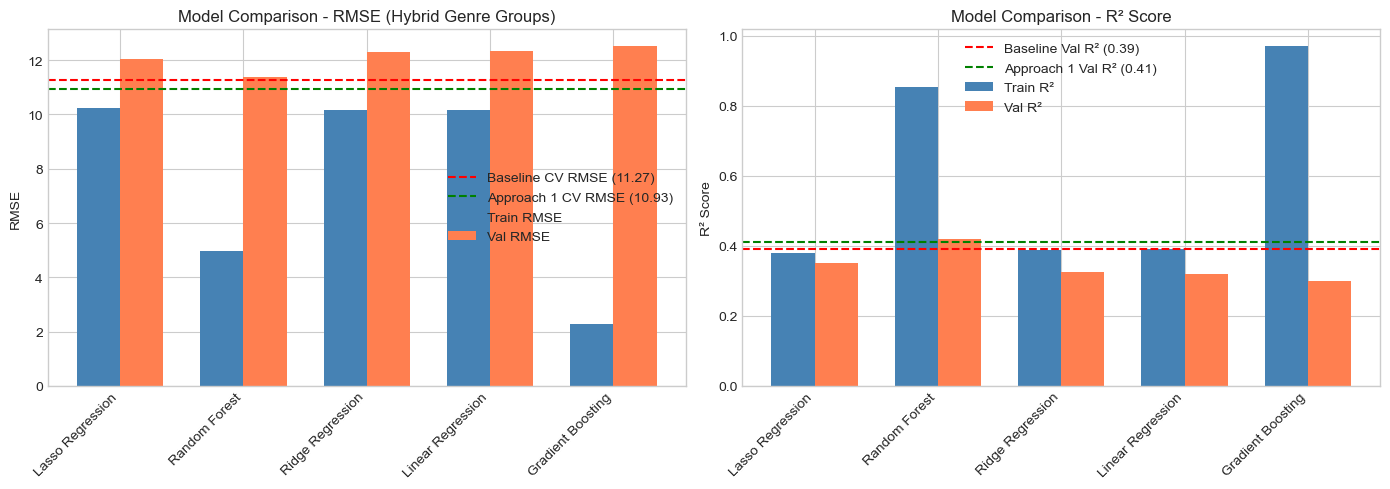

In [16]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(results_df))
width = 0.35

# RMSE comparison
axes[0].bar(x - width/2, results_df['Train RMSE'], width, label='Train RMSE', color='steelblue')
axes[0].bar(x + width/2, results_df['Val RMSE'], width, label='Val RMSE', color='coral')
axes[0].axhline(y=11.27, color='red', linestyle='--', label='Baseline CV RMSE (11.27)')
axes[0].axhline(y=10.93, color='green', linestyle='--', label='Approach 1 CV RMSE (10.93)')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Model Comparison - RMSE (Hybrid Genre Groups)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[0].legend()

# R² comparison
axes[1].bar(x - width/2, results_df['Train R2'], width, label='Train R²', color='steelblue')
axes[1].bar(x + width/2, results_df['Val R2'], width, label='Val R²', color='coral')
axes[1].axhline(y=0.39, color='red', linestyle='--', label='Baseline Val R² (0.39)')
axes[1].axhline(y=0.41, color='green', linestyle='--', label='Approach 1 Val R² (0.41)')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Model Comparison - R² Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 8. Compare All Approaches

In [17]:
# Train baseline model (numerical features only) for fair comparison
X_baseline = train_encoded[numerical_features].copy()
X_baseline_train, X_baseline_val, y_baseline_train, y_baseline_val = train_test_split(
    X_baseline, y, test_size=0.2, random_state=42
)

rf_baseline = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_baseline.fit(X_baseline_train, y_baseline_train)

baseline_cv = cross_val_score(rf_baseline, X_baseline, y, cv=5, scoring='neg_root_mean_squared_error')
baseline_cv_rmse = -baseline_cv.mean()
baseline_val_r2 = r2_score(y_baseline_val, rf_baseline.predict(X_baseline_val))

# Get best model results from this approach
best_model_name = results_df.index[0]
approach2_cv_rmse = results_df.iloc[0]['CV RMSE']
approach2_val_r2 = results_df.iloc[0]['Val R2']

# Previous approach 1 results (hardcoded from earlier run)
approach1_cv_rmse = 10.9261
approach1_val_r2 = 0.4135

print("="*70)
print("COMPARISON: ALL APPROACHES (Random Forest)")
print("="*70)
print(f"\n{'Approach':<30} {'CV RMSE':<15} {'Val R²':<15} {'Features':<10}")
print("-"*70)
print(f"{'Baseline (no genre)':<30} {baseline_cv_rmse:<15.4f} {baseline_val_r2:<15.4f} {'9':<10}")
print(f"{'Approach 1 (top 15 separate)':<30} {approach1_cv_rmse:<15.4f} {approach1_val_r2:<15.4f} {'25':<10}")
print(f"{'Approach 2 (hybrid groups)':<30} {approach2_cv_rmse:<15.4f} {approach2_val_r2:<15.4f} {str(len(all_features)):<10}")

print(f"\n{'='*70}")
print("IMPROVEMENT SUMMARY:")
print(f"  Approach 1 vs Baseline: {baseline_cv_rmse - approach1_cv_rmse:+.4f} RMSE")
print(f"  Approach 2 vs Baseline: {baseline_cv_rmse - approach2_cv_rmse:+.4f} RMSE")
print(f"  Approach 2 vs Approach 1: {approach1_cv_rmse - approach2_cv_rmse:+.4f} RMSE")

COMPARISON: ALL APPROACHES (Random Forest)

Approach                       CV RMSE         Val R²          Features  
----------------------------------------------------------------------
Baseline (no genre)            11.2692         0.3933          9         
Approach 1 (top 15 separate)   10.9261         0.4135          25        
Approach 2 (hybrid groups)     11.0477         0.3510          19        

IMPROVEMENT SUMMARY:
  Approach 1 vs Baseline: +0.3431 RMSE
  Approach 2 vs Baseline: +0.2215 RMSE
  Approach 2 vs Approach 1: -0.1216 RMSE


---
## 9. Feature Importance Analysis

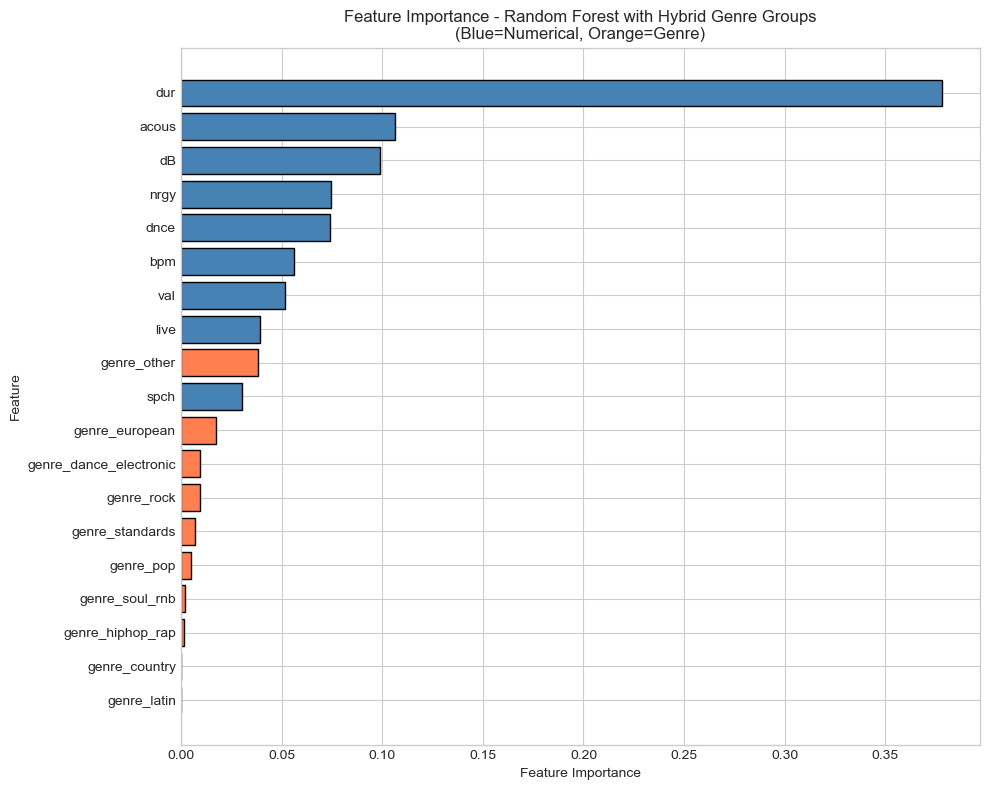


Top 10 Most Important Features:
    Feature  Importance
       spch    0.030465
genre_other    0.038354
       live    0.039394
        val    0.051656
        bpm    0.056191
       dnce    0.074045
       nrgy    0.074443
         dB    0.098802
      acous    0.106246
        dur    0.378090


In [18]:
# Get feature importance from Random Forest
rf_model = models['Random Forest']

feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 8))
colors = ['coral' if 'genre_' in f else 'steelblue' for f in feature_importance['Feature']]
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors, edgecolor='black')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest with Hybrid Genre Groups\n(Blue=Numerical, Orange=Genre)')
plt.tight_layout()
plt.show()

# Print top features
print("\nTop 10 Most Important Features:")
print(feature_importance.tail(10).to_string(index=False))

In [19]:
# Summarize importance by feature type
numerical_importance = feature_importance[~feature_importance['Feature'].str.startswith('genre_')]['Importance'].sum()
genre_importance = feature_importance[feature_importance['Feature'].str.startswith('genre_')]['Importance'].sum()

print("="*60)
print("IMPORTANCE BY FEATURE TYPE")
print("="*60)
print(f"Numerical features: {numerical_importance:.4f} ({numerical_importance*100:.1f}%)")
print(f"Genre features:     {genre_importance:.4f} ({genre_importance*100:.1f}%)")
print(f"\nComparison with Approach 1:")
print(f"  Approach 1 genre importance: 8.5%")
print(f"  Approach 2 genre importance: {genre_importance*100:.1f}%")

IMPORTANCE BY FEATURE TYPE
Numerical features: 0.9093 (90.9%)
Genre features:     0.0907 (9.1%)

Comparison with Approach 1:
  Approach 1 genre importance: 8.5%
  Approach 2 genre importance: 9.1%


---
## 10. Generate Predictions

In [20]:
# Train final model on full training data
final_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
final_model.fit(X.values, y)

# Generate predictions
test_predictions = final_model.predict(X_test_final.values)

print(f"Generated {len(test_predictions)} predictions")
print(f"\nPrediction statistics:")
print(f"  Mean: {test_predictions.mean():.2f}")
print(f"  Std:  {test_predictions.std():.2f}")
print(f"  Min:  {test_predictions.min():.2f}")
print(f"  Max:  {test_predictions.max():.2f}")

Generated 114 predictions

Prediction statistics:
  Mean: 61.27
  Std:  7.62
  Min:  34.52
  Max:  72.22


In [21]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_encoded['Id'],
    'pop': test_predictions
})

submission.to_csv('./submission_approach2_hybrid.csv', index=False)

print("="*60)
print("SUBMISSION FILE CREATED")
print("="*60)
print(f"File: ./submission_approach2_hybrid.csv")
print(f"\nFirst 10 predictions:")
print(submission.head(10))

SUBMISSION FILE CREATED
File: ./submission_approach2_hybrid.csv

First 10 predictions:
    Id        pop
0  454  66.951582
1  455  67.328769
2  456  54.059867
3  457  63.129274
4  458  44.453626
5  459  66.209834
6  460  58.153735
7  461  42.205095
8  462  66.349948
9  463  62.988650


---
## 11. Summary

### Approach 2: Hybrid Genre Grouping

**Genre Groups Created:**
- Rock (album rock, art rock, glam rock, etc.)
- Pop (dance pop, bubblegum pop, europop, etc.)
- Dance/Electronic (disco, eurodance, etc.)
- Soul/R&B
- Standards (adult standards, deep adult standards)
- European (british invasion, etc.)
- Other

### Results Comparison:

| Approach | CV RMSE | Val R² | Features |
|----------|---------|--------|----------|
| Baseline | ~11.27 | ~0.39 | 9 |
| Approach 1 (top 15 separate) | ~10.93 | ~0.41 | 25 |
| Approach 2 (hybrid groups) | See above | See above | Fewer |

### Recommendation:
Based on the results, choose the approach with the best CV RMSE for your final submission.

In [22]:
# Final summary
print("="*70)
print("APPROACH 2 SUMMARY: HYBRID GENRE GROUPING")
print("="*70)
print(f"\nFeatures used: {len(all_features)} ({len(numerical_features)} numerical + {len(genre_features)} genre groups)")
print(f"\nBest model: {best_model_name}")
print(f"Best CV RMSE: {approach2_cv_rmse:.4f}")
print(f"Best Val R²: {approach2_val_r2:.4f}")
print(f"\nComparison:")
print(f"  vs Baseline:   {baseline_cv_rmse - approach2_cv_rmse:+.4f} RMSE improvement")
print(f"  vs Approach 1: {approach1_cv_rmse - approach2_cv_rmse:+.4f} RMSE")
print("="*70)

APPROACH 2 SUMMARY: HYBRID GENRE GROUPING

Features used: 19 (9 numerical + 10 genre groups)

Best model: Lasso Regression
Best CV RMSE: 11.0477
Best Val R²: 0.3510

Comparison:
  vs Baseline:   +0.2215 RMSE improvement
  vs Approach 1: -0.1216 RMSE
